基础绘制接口

d:\condaenvs\mmyolo\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


08/27 20:42:20 - mmengine - WARNING - `Visualizer` backend is not initialized because save_dir is None.


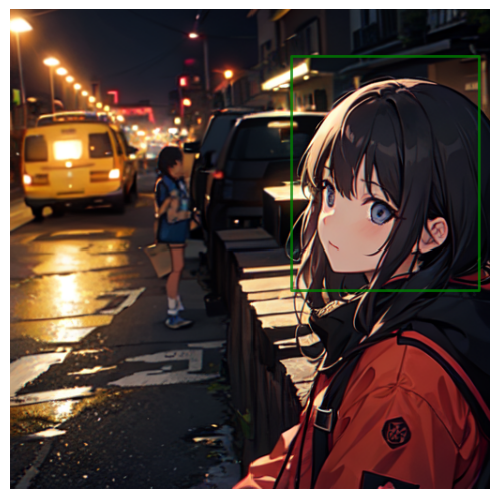

In [1]:
from PIL import Image
import torch
import numpy as np
from mmengine.visualization import Visualizer

image=Image.open('./src/1.png').convert('RGB')
image_n=np.array(image)
visualizer = Visualizer(image=image_n)
visualizer.draw_bboxes(torch.tensor([300,50,500,300]))
visualizer.show()

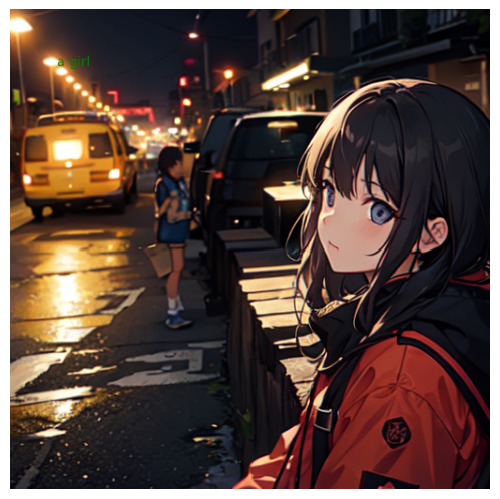

In [2]:
visualizer.set_image(image=image_n)#重新设置图像，否则会保留之前的框
# 线条长度和颜色等，可查看源码
visualizer.draw_texts('a girl',positions=torch.tensor([50,50]))
visualizer.show()

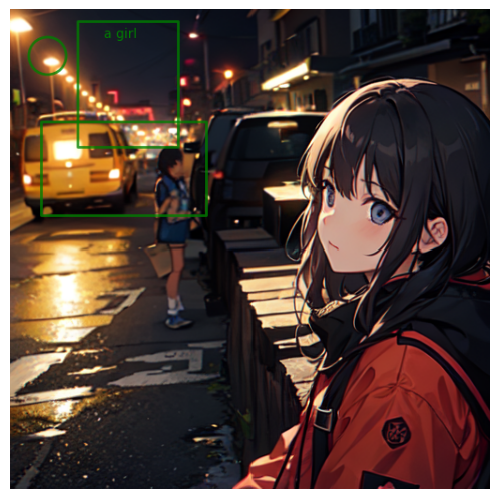

In [3]:
visualizer.set_image(image=image_n)
visualizer.draw_bboxes(torch.tensor([[33, 120, 209, 220], [72, 13, 179, 147]]))
visualizer.draw_texts("a girl",
                      torch.tensor([100, 20])).draw_circles(torch.tensor([40, 50]),
                      torch.tensor([20]))
visualizer.show()
# 圆圈是在文字的位置处调用的，但是和文字文字没有关系

特征图可视化

1. 输入的 Tensor 一般是包括多个通道的，channel_reduction 参数可以将多个通道压缩为单通道，然后和图片进行叠加显示;
    1. squeeze_mean 将输入的 C 维度采用 mean 函数压缩为一个通道，输出维度变成 (1, H, W)
    2. select_max 从输入的 C 维度中先在空间维度 sum，维度变成 (C, )，然后选择值最大的通道
    3. None 表示不需要压缩，此时可以通过 topk 参数可选择激活度最高的 topk 个特征图显示
2. 在 channel_reduction 参数为 None 的情况下，topk 参数生效，其会按照激活度排序选择 topk 个通道，然后和图片进行叠加显示，并且此时会通过 arrangement 参数指定显示的布局
    1. 如果 topk 不是 -1，则会按照激活度排序选择 topk 个通道显示
    2. 如果 topk = -1，此时通道 C 必须是 1 或者 3 表示输入数据是图片，否则报错提示用户应该设置 channel_reduction来压缩通道。
3. 考虑到输入的特征图通常非常小，函数支持输入 resize_shape 参数，方便将特征图进行上采样后进行可视化。

In [ ]:
@staticmethod
def draw_featmap(
    # 输入格式要求为 CHW
    featmap: torch.Tensor,
    # 如果同时输入了 image 数据，则特征图会叠加到 image 上绘制
    overlaid_image: Optional[np.ndarray] = None,
    # 多个通道压缩为单通道的策略
    channel_reduction: Optional[str] = 'squeeze_mean',
    # 可选择激活度最高的 topk 个特征图显示
    topk: int = 10,
    # 多通道展开为多张图时候布局
    arrangement: Tuple[int, int] = (5, 2),
    # 可以指定 resize_shape 参数来缩放特征图
    resize_shape: Optional[tuple] = None,
    # 图片和特征图绘制的叠加比例
    alpha: float = 0.5,
) -> np.ndarray

In [4]:
import numpy as np
import torch
from torchvision.models import resnet18
from torchvision.transforms import ToTensor,Compose,Normalize

def preprocess_image(image,mean,std):
    preprocessing=Compose([ToTensor(),Normalize(mean,std)])
    return preprocessing(image).unsqueeze(0)

model=resnet18(pretrained=True)

def forward_(img):
    x = model.conv1(x)
    x = model.bn1(x)
    x = model.relu(x)
    x = model.maxpool(x)

    x1 = model.layer1(x)
    x2 = model.layer2(x1)
    x3 = model.layer3(x2)
    x4 = model.layer4(x3)
    return x4

model.forward=forward_
image_norm = np.float32(image) / 255
input_tensor = preprocess_image(image_norm,
                                mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
feat = model(input_tensor)[0]

visualizer = Visualizer()
# 注意draw_featmap方法需要接受img作为输入，虽然他是visualizer的一个方法，但是visualizer实例化时并没有传入图像
drawn_img = visualizer.draw_featmap(feat, channel_reduction='select_max')
visualizer.show(drawn_img)

d:\condaenvs\mmyolo\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\condaenvs\mmyolo\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\25832/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
 66%|██████▌   | 29.3M/44.7M [00:04<00:02, 6.18MB/s]


KeyboardInterrupt: 

In [5]:
# 融合原图和特征图
drawn_img = visualizer.draw_featmap(feat, image, channel_reduction='select_max')
visualizer.show(drawn_img)

NameError: name 'feat' is not defined

In [ ]:
# 多个特征图
draw_featmap=visualizer.draw_featmap(feat,image_n,channel_reduction=None,topk=5,arrangement=(2,3))
visualizer.show(draw_featmap)

基础存储接口

In [13]:
# 存储绘制后的图片
from mmengine.visualization import Visualizer

visualizer=Visualizer(image=image_n,
                        vis_backends=[dict(type='LocalVisBackend')],
                        save_dir='./src')
visualizer.draw_bboxes(torch.tensor([[33,120,209,220],[72,13,179,147]]))
visualizer.draw_texts('a girl',torch.tensor([10,20]))
visualizer.draw_circles(torch.tensor([40,50]),torch.tensor([20]))

#会生成src/vis_data/vis_image/demo_0.jpg
visualizer.add_image('demo',visualizer.get_image())

In [8]:
#step参数控制文件名后缀
visualizer.add_image('demo',visualizer.get_image(),step=1)
visualizer.add_image('demo',visualizer.get_image(),step=3)  

In [11]:
#使用其他后端
# TensorboardVisBackend
visualizer = Visualizer(image=image_n,
                        vis_backends=[dict(type='TensorboardVisBackend')],
                        save_dir='./src')
# 或者 WandbVisBackend
visualizer = Visualizer(image=image_n,
                        vis_backends=[dict(type='WandbVisBackend')],
                        save_dir='./src')

In [ ]:
#存储特征图
visualizer=Visualizer(vis_backends=[dict(type='LocalVisBackend')],
    save_dir='./src')
drawn_img=visualizer.draw_featmap(feat,image,channel_reduction=None,
    topk=5,arrangement=(2,3)) 
visualizer.add_image('feat',drawn_img) 

In [14]:
#存储loss等标量数据
#会生成src/vis_data/scalars.json
visualizer.add_scalar('loss',0.2,step=0)
visualizer.add_scalar('loss',0.1,step=1)
#保存acc
visualizer.add_scalar('acc',0.7,step=0)
visualizer.add_scalar('acc',0.8,step=1)
#一次性保存多个标量数据
visualizer.add_scalars({'loss':0.3,'acc':0.8},step=3)

In [ ]:
#保存配置文件
from mmengine import Config
cfg=Config.fromfile('...')
visualizer.add_config(cfg)

多后端存储

In [ ]:
visualizer = Visualizer(image=image,
                        vis_backends=[dict(type='TensorboardVisBackend'),
                                      dict(type='LocalVisBackend')],
                        save_dir='./src')
# 会生成 temp_dir/vis_data/events.out.tfevents.xxx 文件
visualizer.draw_bboxes(torch.tensor([[33, 120, 209, 220], [72, 13, 179, 147]]))
visualizer.draw_texts("a girl", torch.tensor([10, 20]))
visualizer.draw_circles(torch.tensor([40, 50]), torch.tensor([20]))

visualizer.add_image('demo', visualizer.get_image())

In [ ]:
#多个存储后端有相同的类型，为了区分必须为每一个后端设置name字段
visualizer = Visualizer(
    image=image,
    vis_backends=[
        dict(type='TensorboardVisBackend', name='tb_1', save_dir='temp_dir_1'),
        dict(type='TensorboardVisBackend', name='tb_2', save_dir='temp_dir_2'),
        dict(type='LocalVisBackend', name='local')
    ],
    save_dir='./src')

In [22]:
# 在程序初始化时候调用
visualizer1 = Visualizer.get_instance(
    name='vis',
    vis_backends=[dict(type='LocalVisBackend')]
)

# 在任何代码位置都可调用
visualizer2 = Visualizer.get_current_instance()
visualizer2.add_scalar('map', 0.7, step=0)

id(visualizer1) == id(visualizer2)

/root/anaconda3/envs/mmyolo/lib/python3.10/site-packages/mmengine/utils/manager.py:113: UserWarning: <class 'mmengine.visualization.visualizer.Visualizer'> instance named of vis has been created, the method `get_instance` should not accept any other arguments
  warnings.warn(


True

In [ ]:
from mmengine.registry import VISUALIZERS

visualizer_cfg = dict(type='Visualizer',
                      name='vis_new',
                      vis_backends=[dict(type='LocalVisBackend')])
VISUALIZERS.build(visualizer_cfg)

#说实话，这两设计的完全不会让人联想到这是一个东西

扩展存储后端和可视化器

In [ ]:
#调用特定的存储后端，使用experiments属性可以获取对应后端的对象
visualizer = Visualizer(image=image,
                        vis_backends=[dict(type='WandbVisBackend')],
                        save_dir='./src')

# 获取 WandB 对象
wandb = visualizer.get_backend('WandbVisBackend').experiment
# 追加表格数据
table = wandb.Table(columns=["step", "mAP"])
table.add_data(1, 0.2)
table.add_data(2, 0.5)
table.add_data(3, 0.9)
# 保存
wandb.log({"table": table})

In [ ]:
#扩展存储后端，继承BaseVisBackend并实现各种add_xx方法即可
#这倒是提醒了可以去看看tensorboard这种非本地后端的add_xx方法将图像保存到哪里了

from mmengine.registry import VISBACKENDS
from mmengine.visualization import BaseVisBackend

@VISBACKENDS.register_module()
class DemoVisBackend(BaseVisBackend):
    def add_image(self, **kwargs):
        pass

visualizer = Visualizer(vis_backends=[dict(type='DemoVisBackend')],
                        save_dir='./src')
visualizer.add_image('demo',image)

In [ ]:
#扩展可视化器：继承Visualizer并实现add_datasample方法
from mmengine.registry import VISUALIZERS

@VISUALIZERS.register_module()
class DetLocalVisualizer(Visualizer):
    def add_datasample(self,
                       name,
                       image: np.ndarray,
                       data_sample: Optional['BaseDataElement'] = None,
                       draw_gt: bool = True,
                       draw_pred: bool = True,
                       show: bool = False,
                       wait_time: int = 0,
                       step: int = 0) -> None:
        pass

visualizer_cfg = dict(type='DetLocalVisualizer',
                      vis_backends=[dict(type='WandbVisBackend')],
                      name='visualizer')

# 全局初始化
VISUALIZERS.build(visualizer_cfg)

# 任意代码位置
det_local_visualizer = Visualizer.get_current_instance()
det_local_visualizer.add_datasample('det', image, data_sample)